
# Convolutional Neural Network CNN
1. Using Word2Vec implementing CNN model
2. Dispaly Confusion Matrix, precision, recall and F1-score
3. Display few prediction using predict module. 
4. Get 10-fold Average of the CNN model.

In [1]:
from __future__ import division, print_function

# dataframe
import pandas as pd

# numpy array
import numpy as np

# figures visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
import seaborn as sns

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

# word2vec
import gensim 
from gensim import models
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

# CNN model and keras preprocessing
import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, Conv2D, GlobalMaxPooling2D
from keras.models import Sequential
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# nltk data preprocessing
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize 
from nltk.stem import WordNetLemmatizer

# stopword - remove buzz word
from nltk.corpus import stopwords

# splitting data
from sklearn.model_selection import train_test_split

# punctuation - data imbalance
import collections
import re
import string

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

In [2]:
# original english file
filename  = 'Eng-Hin-data/hindi-anot-shuffled'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.columns = ['Text', 'Label']

In [3]:
# Run only for English data 
orig_df["Text"] = orig_df["Text"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)
data = orig_df

In [4]:
orig_df.head

<bound method NDFrame.head of                                                    Text Label
0     'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #Is...     0
1        '@SanjayGadhiaINC @IndiaToday18 अज़ाबे इलाही 👍     1
2     'आखिर अब #सुशांत_सिंह_राजपूत जी को न्याय मिल ज...     0
3     'अमीन के 500 से अधिक छात्रों ने सर्वे भवन के ग...     0
4     '@deoriapolice @Uppolice @myogiadityanath @spg...     0
...                                                 ...   ...
8788                  '@atullondhe राहुल गांधी जिंदाबाद     0
8789  'पैगंबर हज़रत मुहम्मद सल्लल्लाहु अलैहि वसल्लम ...     1
8790  'कर्नाटक बेंगलुरू में अल्लाह मोहम्मद गांडू के ...     2
8791  'अच्छी खबर है ऐसे एक एक कर सभी जेहादी भारतीय फ...     2
8792  '@Ruzena__Malik जनता चाइना से दीवाली की लड़ी ख...     0

[8793 rows x 2 columns]>

In [5]:
orig_df.Text[6]

"'आज के दिन ही मेरा क्रिकेट प्रेम भी समाप्त हो गया"

In [6]:
# Run only for non english data 
filename  = 'Eng-Hin-data/hindi-anot-shuffled'

if not path.exists(filename + '-translated.csv'):
    print("Not Exist")
    p_data = pd.read_csv("Eng-Hin-data/hindi-anot-shuffled.csv")
    #data =  data.drop('Strength',1)
    translator = Translator()
    col_one_list = p_data['Text'].tolist()
    len(col_one_list)
    result = []
    for i  in range(len(col_one_list)):
        try:
            trans = translator.translate(col_one_list[i], dest='en')
            result.append(trans.text)
        except:
                result.append(col_one_list[i])
    p_data['Text'] = result
    p_data.to_csv(filename + '-translated.csv', index=False)
    df = pd.read_csv(filename + '-translated.csv',  
                   delimiter=',')
    df.columns = ['Text', 'Label']
    df.head(15)
    df["Text"] = df["Text"].astype(str)
    df["Label"] = df["Label"].astype(str)
    data = df
else:
    print("Exist")
    df = pd.read_csv(filename + '-translated.csv',  
                   delimiter=',')
    df.columns = ['Text', 'Label']
    df.head(15)
    df["Text"] = df["Text"].astype(str)
    df["Label"] = df["Label"].astype(str)
    data = df

Exist


In [7]:
df.Text[6]

"'Today also my cricket love has ended"

### Class count

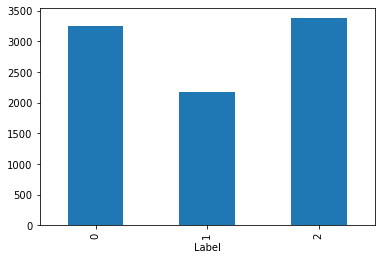

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [9]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3374
0    3245
1    2174
Name: Label, dtype: int64

### Data Preprocessing

In [10]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceFourColon(x))

In [11]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Text'] = data['Text'].apply(lambda x: textPattern(x))

In [12]:
data.shape

(8793, 2)

In [13]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Text]

In [14]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [15]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [16]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [17]:
# Removing Stopwords
stoplist = stopwords.words('english')

In [18]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [19]:
zero  = []
one = []
two = []
for l in data.Label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
        two.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        two.append(0)
    elif l == '2':
        zero.append(0)
        one.append(0)
        two.append(1)
        
data['0']= zero
data['1']= one
data['2']= two

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2']]

In [20]:
category_id = []
for l in data.Label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
    elif l == '2':
        category_id.append('2')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2', 'Category_id' ]]
data.head(9)

,Text_Final,tokens,Label,0,1,2,Category_id
0,happy diwali greeting gaza friend israelibombing,"[happy, diwali, greeting, gaza, friend, israel...",0,1,0,0,0
1,sanjaygadhiainc indiatoday18 azabe elahi,"[sanjaygadhiainc, indiatoday18, azabe, elahi]",1,0,1,0,1
2,sushant singh rajput ji get justice riya chakr...,"[sushant, singh, rajput, ji, get, justice, riy...",0,1,0,0,0
3,500 student amin performed half - naked gate s...,"[500, student, amin, performed, half, -, naked...",0,1,0,0,0
4,deoriapolice uppolice myogiadityanath spgrpall...,"[deoriapolice, uppolice, myogiadityanath, spgr...",0,1,0,0,0
5,khanumarfa jihadi thinking rahat indouri wrap ...,"[khanumarfa, jihadi, thinking, rahat, indouri,...",2,0,0,1,2
6,today also cricket love ha ended,"[today, also, cricket, love, ha, ended]",0,1,0,0,0
7,jihadi thought work poet celebrate sorrow wa a...,"[jihadi, thought, work, poet, celebrate, sorro...",2,0,0,1,2
8,sanatan44005733 azadsamajparty0 manikar3002388...,"[sanatan44005733, azadsamajparty0, manikar3002...",2,0,0,1,2


In [21]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 20 % for testing. We use random state so every time we get the same training and testing data.

In [22]:
data.shape

(8793, 7)

In [23]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)


In [24]:
# # total training words
totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

# # Storing Length of the training sentence
lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

# # training Vocabulary size
trainingVocabSize = sorted(list(set(totalTrainingWords)))

## Total number of lines
linesCount = len(data_train["tokens"])

### Load Google Word2vec model

In [25]:
word2vec_path = 'GoogleNews-vectors-negative300.bin'

In [26]:
from gensim import models
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)


In [27]:
word2vec

In [28]:
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 300


### Tokenize and Pad sequences

In [29]:
tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 10971 unique tokens.


In [30]:
cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [31]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(10972, 300)


In [32]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)

### Define CNN

The model is from the paper 'Convolutional Neural Networks for Sentence Classification' we have updated the network according to our requirement [1]

In [33]:
label_names = ['0', '1', '2']

In [34]:
def ConvolutionalNeuralNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    # Embedding layer
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    
    #Kernal (window) size
    filter_sizes = [2,3,4,5]

    # Convolution Layer and max-pooling
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=512, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
        
    l_merge = concatenate(convs, axis=1)
    
    # softmax layer for multiclass identification 
    x = Dropout(0.1)(l_merge)  
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss= 'categorical_crossentropy',
                 optimizer = keras.optimizers.RMSprop(learning_rate=1e-3),
#                    optimizer='adam',
                  metrics=['accuracy'])
    return model

In [35]:
# Splitting train data into X_train and y_train
y_train = data_train[label_names].values
x_train = cnnTrainData
y_tr = y_train

In [36]:
# Splitting train data into X_test and y_test
y_test = data_test[label_names].values
x_test = cnnTestData
y_tst = y_test

In [37]:
model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

In [38]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 300)     3291600     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 149, 512)     307712      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 148, 512)     461312      embedding[0][0]                  
_______________________________________________________________________________________

### Train CNN

In [39]:
num_epochs = 10
batch_size = 512

In [40]:
history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/10
14/14 [==============================] - 34s 2s/step - loss: 2.9630 - accuracy: 0.4650 - val_loss: 0.7909 - val_accuracy: 0.6073
Epoch 2/10
14/14 [==============================] - 34s 2s/step - loss: 0.7320 - accuracy: 0.6470 - val_loss: 0.8441 - val_accuracy: 0.5871
Epoch 3/10
14/14 [==============================] - 34s 2s/step - loss: 0.6458 - accuracy: 0.7009 - val_loss: 0.5833 - val_accuracy: 0.7273
Epoch 4/10
14/14 [==============================] - 34s 2s/step - loss: 0.5872 - accuracy: 0.7236 - val_loss: 0.6893 - val_accuracy: 0.6894
Epoch 5/10
14/14 [==============================] - 34s 2s/step - loss: 0.5526 - accuracy: 0.7443 - val_loss: 0.5805 - val_accuracy: 0.7285
Epoch 6/10
14/14 [==============================] - 34s 2s/step - loss: 0.5391 - accuracy: 0.7520 - val_loss: 0.5454 - val_accuracy: 0.7399
Epoch 7/10
14/14 [==============================] - 34s 2s/step - loss: 0.4938 - accuracy: 0.7660 - val_loss: 0.5475 - val_accuracy: 0.7386
Epoch 8/10
14/14 [==

In [41]:
# evaluate on test data
results = model.evaluate(x_test, y_tst)

28/28 [==============================] - 2s 60ms/step - loss: 0.5892 - accuracy: 0.7364


In [42]:
# predict model
predictions = model.predict(cnnTestData, batch_size=1024, verbose=1)

1/1 [==============================] - 0s 2ms/step


### Testing few sentences using our model

In [43]:

labels = ['0', '1', '2']

def makeprediction(texts):
    tk = Tokenizer()
    tk.fit_on_texts(texts)
    index_list = tk.texts_to_sequences(texts)
    x_train = pad_sequences(index_list, maxlen=150)
    pred = model.predict(x_train)
    result = labels[np.argmax(pred)]
    return result

In [44]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [45]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.7363636363636363

In [46]:
data_test.Label.value_counts()

2    351
0    314
1    215
Name: Label, dtype: int64

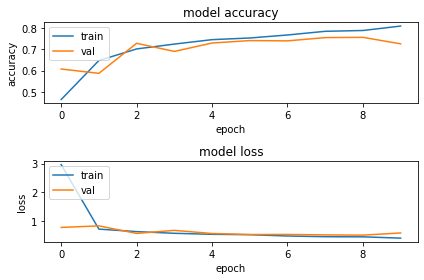

In [47]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [48]:
results = confusion_matrix(data_test.Label, prediction_labels)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(data_test.Label, prediction_labels))
print ('Report : ')
print (classification_report(data_test.Label, prediction_labels))

Confusion Matrix :
[[217  22  75]
 [ 27 157  31]
 [ 54  23 274]]
Accuracy Score : 0.7363636363636363
Report : 
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       314
           1       0.78      0.73      0.75       215
           2       0.72      0.78      0.75       351

    accuracy                           0.74       880
   macro avg       0.74      0.73      0.74       880
weighted avg       0.74      0.74      0.74       880



                        Convolution Neural Network


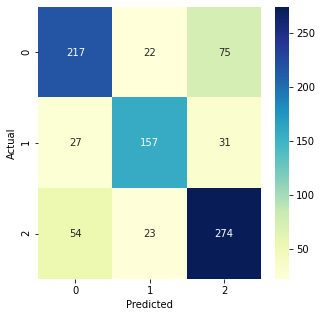

In [49]:
from sklearn.metrics import confusion_matrix
print("                        Convolution Neural Network")
conf_mat = confusion_matrix(data_test.Label, prediction_labels)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap ='YlGnBu',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Testing CNN using KFold cross validation

In [50]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import zscore
from sklearn import metrics
import tensorflow as tf
import random

f_score=[]
fold = 10
label_names = ['0', '1', '2']
num_epochs = 5
batch_size = 32
#oos_y = []
#oos_pred = []
results = []
#for train, test in kf.split(data["tokens"], data['Label']):

for i in range(fold):
    print("Fold: ", i+1)
    random_num = np.random.randint(1,7000, 1)[0]
    data_train, data_test = train_test_split(data, test_size=0.10, shuffle = True, random_state = random_num)

    # # total training words
    totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

    # # Storing Length of the training sentence
    lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

    # # training Vocabulary size
    trainingVocabSize = sorted(list(set(totalTrainingWords)))

    ## Total number of lines
    linesCount = len(data_train["tokens"])
    
    tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
    tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
    training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

    train_word_index = tokenizer.word_index
    cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
    
    for word,index in train_word_index.items():
        train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
        
    test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
    cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)
    
    # Splitting train data into X_train and y_train
    y_train = data_train[label_names].values
    x_train = cnnTrainData
    y_tr = y_train
    
    # Splitting train data into X_test and y_test
    y_test = data_test[label_names].values
    x_test = cnnTestData
    y_tst = y_test
    
    # create model
    model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))
    
    #Train Model
    history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)
      
    # model evaluate
    
    print("Results for current fold:")
    results.append(model.evaluate(x_test, y_tst, batch_size=128))

#     predictions = model.predict(cnnTestData, batch_size=1024, verbose=0)
#     oos_y.append(y_test)
#     oos_pred.append(predictions)
    
    #score = np.sqrt(metrics.mean_squared_error(predictions, y_test))
#    f_score.append(count)

model.save('model_CNN.h5')    

Fold:  1
Epoch 1/5
223/223 [==============================] - 43s 193ms/step - loss: 0.8614 - accuracy: 0.6609 - val_loss: 0.7388 - val_accuracy: 0.6199
Epoch 2/5
223/223 [==============================] - 42s 189ms/step - loss: 0.5558 - accuracy: 0.7357 - val_loss: 0.5850 - val_accuracy: 0.7222
Epoch 3/5
223/223 [==============================] - 42s 188ms/step - loss: 0.4908 - accuracy: 0.7755 - val_loss: 0.6420 - val_accuracy: 0.7449
Epoch 4/5
223/223 [==============================] - 42s 191ms/step - loss: 0.4433 - accuracy: 0.7953 - val_loss: 0.6920 - val_accuracy: 0.7285
Epoch 5/5
223/223 [==============================] - 42s 190ms/step - loss: 0.4180 - accuracy: 0.8121 - val_loss: 0.7361 - val_accuracy: 0.7576
Results for current fold:
7/7 [==============================] - 1s 197ms/step - loss: 0.7821 - accuracy: 0.7227
Fold:  2
Epoch 1/5
223/223 [==============================] - 43s 191ms/step - loss: 0.8441 - accuracy: 0.6561 - val_loss: 0.5964 - val_accuracy: 0.6970
Epoch

In [51]:
import statistics 
# for i in range(len(results)):
#     print("Fold: ", i+1)
#     print("test loss, test acc:", results[i])

score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)

Kfold Mean:  0.7539772689342499


In [52]:
# 0
texts = ["@'England look to clinch Pakistan test series before step into unknown"]
print(makeprediction(texts))

2


In [53]:
# 2
texts = ["@_ROB_29 If this was a Muslim girl in Afghanistan you'd call her a terrorist"]
print(makeprediction(texts))

0


In [54]:
# 0
texts = ["''In what hopscotch? Cricket?"]
print(makeprediction(texts))

2


In [55]:
# 1
texts = ["My tl is filled with Shia-Sunni controversy. I should've deactivated before Moharram started."]
print(makeprediction(texts))

2


### Reference
[1] "Convolutional Neural Networks for Sentence Classification" by Yoon Kim
